In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve


df = pd.read_csv("dataset_elpino.csv", sep=";", encoding="latin1")

# Tabla maestra de GRD
grd_master = pd.read_excel("Tablas maestras bases GRD.xlsx")

# CIE-9 (procedimientos)
cie9 = pd.read_excel("CIE-9.xlsx")

# CIE-10 (diagnósticos)
cie10 = pd.read_excel("CIE-10.xlsx")

# Limpiar nombres de columnas
df.columns = [col.strip().replace(" ", "_") for col in df.columns]

# Columnas relevantes
diagnosticos = [col for col in df.columns if "Diag_" in col]
procedimientos = [col for col in df.columns if "Proced_" in col]

In [4]:
model = BalancedRandomForestClassifier(n_estimators=200, random_state=42)

In [5]:
# Limpiar códigos en df
def limpiar_codigo(cadena):
    return cadena.split(" - ")[0].strip() if pd.notna(cadena) else ""

# Aplicar a todas las columnas de diagnósticos
diagnosticos_columns = [col for col in df.columns if "Diag" in col]
for col in diagnosticos_columns:
    df[col + "_cod"] = df[col].apply(limpiar_codigo)

# Fusionar con CIE-10 para cada diagnóstico
for col in diagnosticos_columns:
    df = df.merge(
        cie10[["Código", "Categoría"]],
        left_on=col + "_cod",
        right_on="Código",
        how="left",
        suffixes=("", f"_{col}")
    )

In [6]:
# Asegurar que los códigos en cie9 son strings
cie9["Código"] = cie9["Código"].astype(str).str.replace(",", ".").str.strip()

# Procesar procedimientos
for col in procedimientos:
    # Limpiar códigos
    df[col + "_cod"] = df[col].apply(limpiar_codigo)
    df[col + "_cod"] = df[col + "_cod"].astype(str)  # Convertir a string
    df[col + "_cod"] = df[col + "_cod"].replace(["nan", "None", "NaT"], "").str.strip()

    # Hacer merge con CIE-9
    df = df.merge(
        cie9[["Código", "Descripción"]].astype({"Código": str}),  # Asegurar tipo string
        left_on=col + "_cod",
        right_on="Código",
        how="left",
        suffixes=("", f"_{col}")
    )

In [7]:
pd.ExcelFile("Tablas maestras bases GRD.xlsx").sheet_names

['Hospitales',
 'Tipo de Pabellon',
 'IR - GRD',
 'Severidad GRD',
 'Mortalidad GRD']

In [8]:
# Cargar cada hoja individualmente
archivo_grd = "Tablas maestras bases GRD.xlsx"
hosp = pd.read_excel(archivo_grd, sheet_name="Hospitales")
pabellon = pd.read_excel(archivo_grd, sheet_name="Tipo de Pabellon")
grd = pd.read_excel(archivo_grd, sheet_name="IR - GRD")
severidad = pd.read_excel(archivo_grd, sheet_name="Severidad GRD")
mortalidad = pd.read_excel(archivo_grd, sheet_name="Mortalidad GRD")

# Renombrar col
hosp.columns = ["Codigo_Hospital", "Nombre_Hospital"]
pabellon.columns = ["Codigo_Pabellon", "Nombre_Pabellon"]
grd.columns = ["Codigo_GRD", "Nombre_GRD"]
severidad.columns = ["Codigo_Severidad", "Nombre_Severidad"]
mortalidad.columns = ["Codigo_Mortalidad", "Nombre_Mortalidad"]

# Fusionar todas las tablas en una sola
grd_master = grd.copy()
grd_master = grd_master.merge(severidad, left_on="Codigo_GRD", right_on="Codigo_Severidad", how="left")
grd_master = grd_master.merge(mortalidad, left_on="Codigo_GRD", right_on="Codigo_Mortalidad", how="left")
grd_master = grd_master.merge(pabellon, left_on="Codigo_GRD", right_on="Codigo_Pabellon", how="left")
grd_master = grd_master.merge(hosp, left_on="Codigo_GRD", right_on="Codigo_Hospital", how="left")

diagnosticos = [col for col in df.columns if "Diag_" in col]
procedimientos = [col for col in df.columns if "Proced_" in col]

In [9]:
# Seleccionamos todas las columnas que contienen la categoría de diagnóstico
categorias_diag = df.filter(like="Categoría_Diag").columns

# Contamos cuántas veces aparece una categoría específica
df["Conteo_Infecciosas"] = df[categorias_diag].apply(
    lambda fila: (fila == "Enfermedades infecciosas").sum(), axis=1
)

# Primero seleccionamos columnas que tengan información sobre el tipo de procedimiento
tipo_proced_cols = df.filter(like="Descripción_Proced").columns

df["Procedimiento_Complejo"] = df[tipo_proced_cols].apply(
    lambda fila: fila.str.contains("Complejo", na=False).any(), axis=1
)

                                                                                          precision    recall  f1-score   support

                                             071141 - PH COLECISTECTOMÃA LAPAROSCÃPICA       0.88      0.48      0.62        63
                                                    134161 - MH TRASTORNOS DEL ANTEPARTO       0.89      0.51      0.65        65
                                                                    146101 - PH CESÃREA       0.89      0.82      0.85       163
146121 - PH PARTO VAGINAL CON PROCED., EXCEPTO ESTERILIZACIÃN Y/O DILATACIÃN Y LEGRADO       0.84      0.92      0.88       129
                                                               146131 - PH PARTO VAGINAL       0.87      0.82      0.85       108
                     158171 - MH NEONATO, PESO AL NACER >2499 GR SIN PROCEDIMIENTO MAYOR       0.73      0.76      0.74        78
                                                                                   Otros 

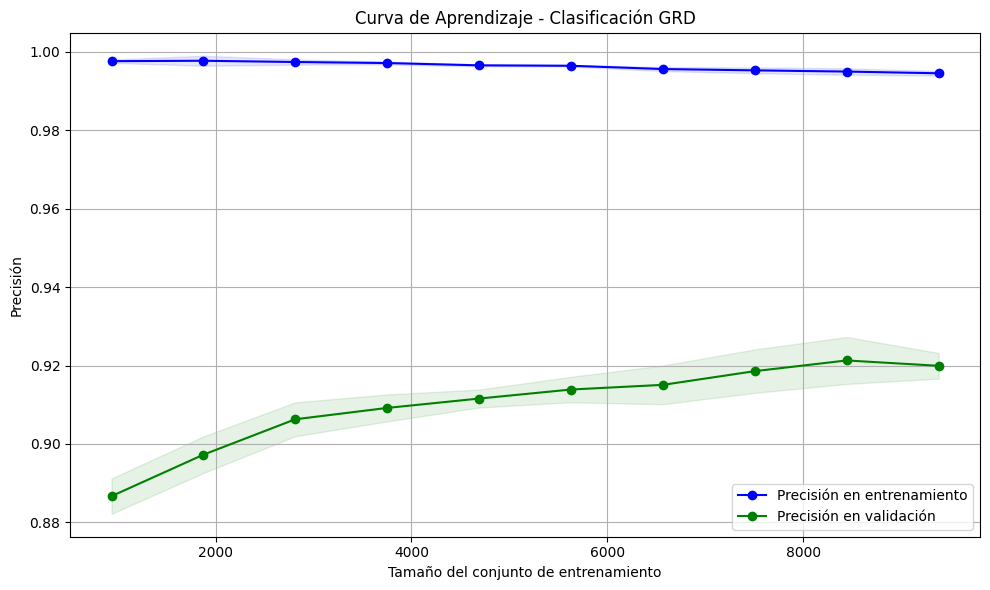

In [10]:
min_samples = 300
grd_counts = df['GRD'].value_counts()
minority_grds = grd_counts[grd_counts < min_samples].index
df['GRD_processed'] = df['GRD'].replace(dict.fromkeys(minority_grds, 'Otros'))

# Definir features y target
features = ['Conteo_Infecciosas', 'Procedimiento_Complejo', 'Edad_en_aÃ±os', 'Sexo'] + \
           [col for col in df.columns if "Categoría" in col or "Severidad" in col]
features = [f for f in features if f in df.columns]  # Filtra columnas existentes

y = df['GRD_processed']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Identificar columnas
num_cols = ['Edad_en_aÃ±os', 'Conteo_Infecciosas']  # Columnas numéricas
cat_cols = [col for col in features if col not in num_cols]  # Columnas categóricas

# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

# Aplicar transformación
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Codificar target
le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)

# Entrenar modelo
model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
model.fit(X_train_processed, y_train_encoded)

# Evaluar
y_pred = model.predict(X_test_processed)
print(classification_report(y_test_encoded, y_pred, target_names=le_y.classes_))


# Obtener curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train_processed,
    y=y_train_encoded,
    cv=5,  # validación cruzada con 5 divisiones
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Calcular media y desviación estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Precisión en entrenamiento")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Precisión en validación")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.title("Curva de Aprendizaje - Clasificación GRD")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()

In [11]:
print(y.value_counts())

GRD_processed
Otros                                                                                       11634
146101 - PH CESÃREA                                                                          816
146121 - PH PARTO VAGINAL CON PROCED., EXCEPTO ESTERILIZACIÃN Y/O DILATACIÃN Y LEGRADO      643
146131 - PH PARTO VAGINAL                                                                     538
158171 - MH NEONATO, PESO AL NACER >2499 GR SIN PROCEDIMIENTO MAYOR                           389
134161 - MH TRASTORNOS DEL ANTEPARTO                                                          325
071141 - PH COLECISTECTOMÃA LAPAROSCÃPICA                                                   317
Name: count, dtype: int64


In [12]:
print("Columnas del DataFrame:", df.columns.tolist())

Columnas del DataFrame: ['Diag_01_Principal_(cod+des)', 'Diag_02_Secundario_(cod+des)', 'Diag_03_Secundario_(cod+des)', 'Diag_04_Secundario_(cod+des)', 'Diag_05_Secundario_(cod+des)', 'Diag_06_Secundario_(cod+des)', 'Diag_07_Secundario_(cod+des)', 'Diag_08_Secundario_(cod+des)', 'Diag_09_Secundario_(cod+des)', 'Diag_10_Secundario_(cod+des)', 'Diag_11_Secundario_(cod+des)', 'Diag_12_Secundario_(cod+des)', 'Diag_13_Secundario_(cod+des)', 'Diag_14_Secundario_(cod+des)', 'Diag_15_Secundario_(cod+des)', 'Diag_16_Secundario_(cod+des)', 'Diag_17_Secundario_(cod+des)', 'Diag_18_Secundario_(cod+des)', 'Diag_19_Secundario_(cod+des)', 'Diag_20_Secundario_(cod+des)', 'Diag_21_Secundario_(cod+des)', 'Diag_22_Secundario_(cod+des)', 'Diag_23_Secundario_(cod+des)', 'Diag_24_Secundario_(cod+des)', 'Diag_25_Secundario_(cod+des)', 'Diag_26_Secundario_(cod+des)', 'Diag_27_Secundario_(cod+des)', 'Diag_28_Secundario_(cod+des)', 'Diag_29_Secundario_(cod+des)', 'Diag_30_Secundario_(cod+des)', 'Diag_31_Secunda

PRUEBAS


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 141 (\x8d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


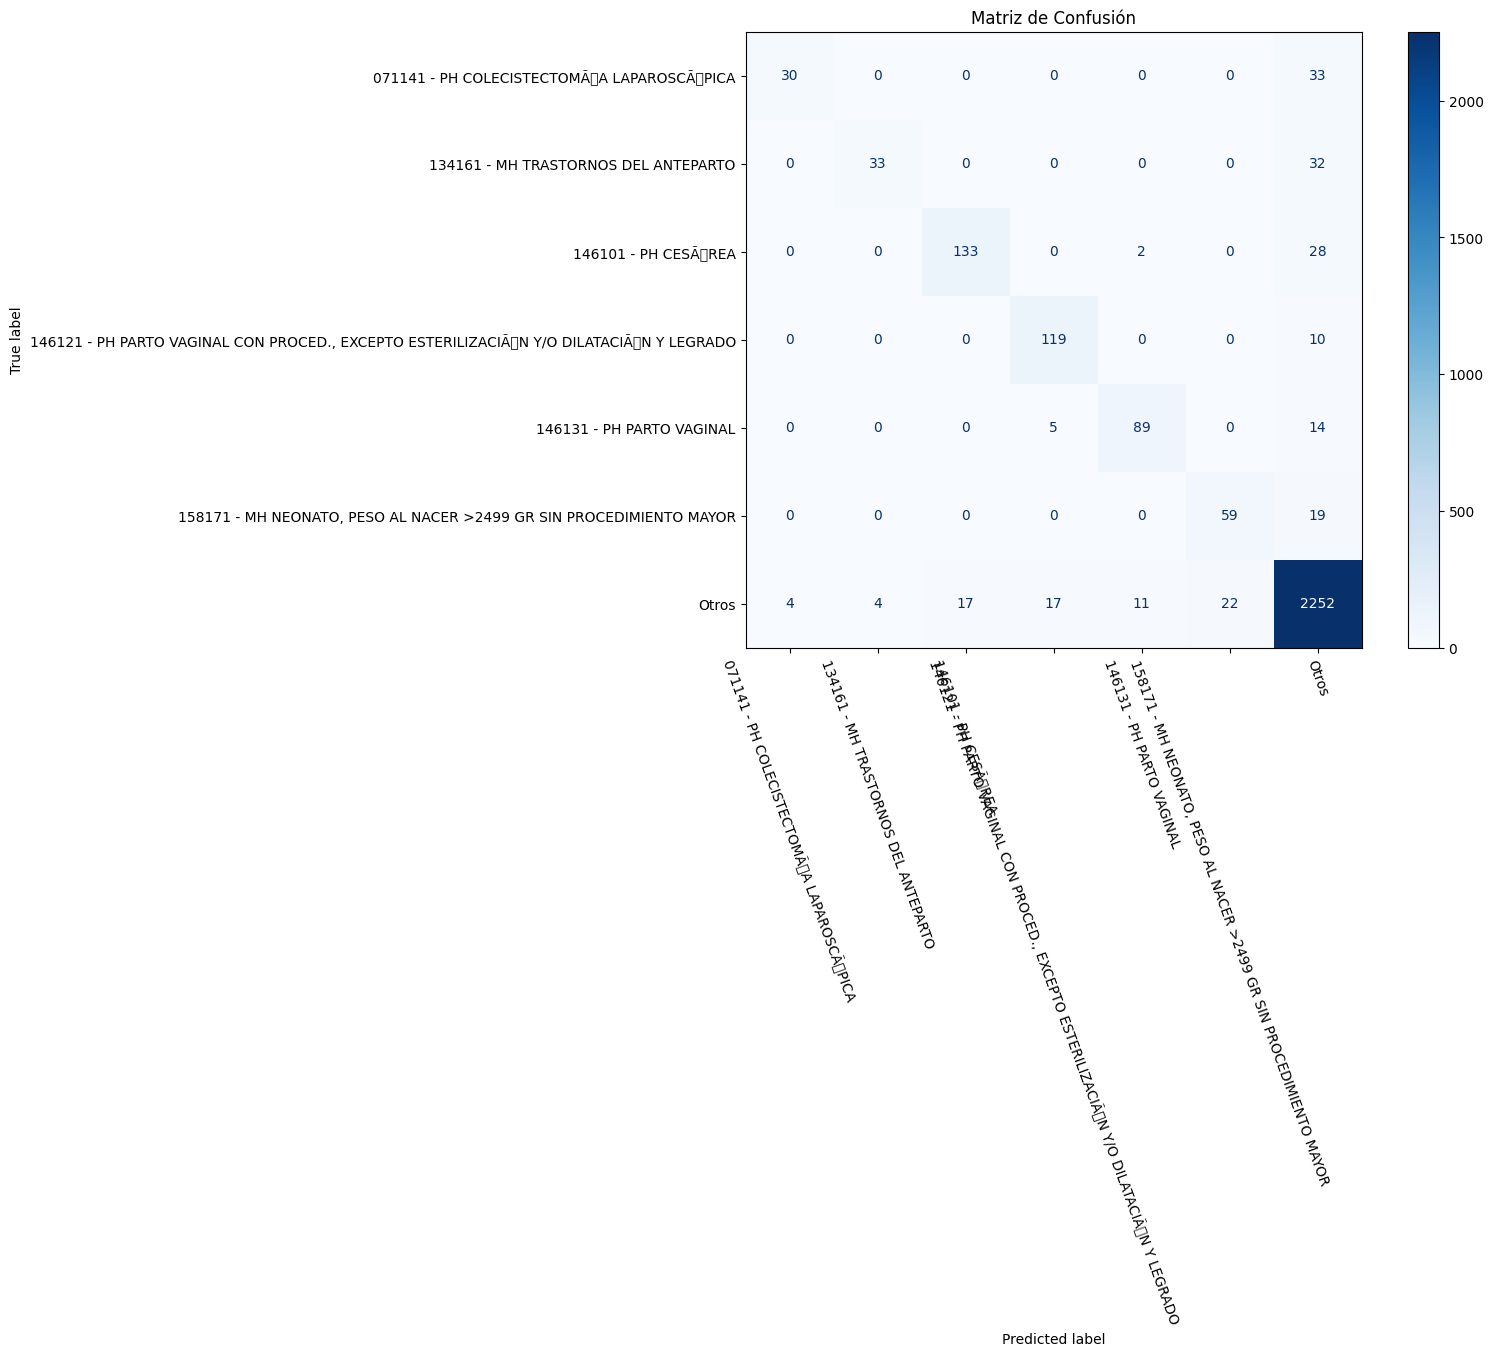

In [13]:
cm = confusion_matrix(y_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_y.classes_)
fig, ax = plt.subplots(figsize=(12, 8))
disp.plot(ax=ax, cmap='Blues')
plt.xticks(rotation=-70)
plt.title("Matriz de Confusión")
plt.show()

<ipython-input-14-0a86b9c41840>:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


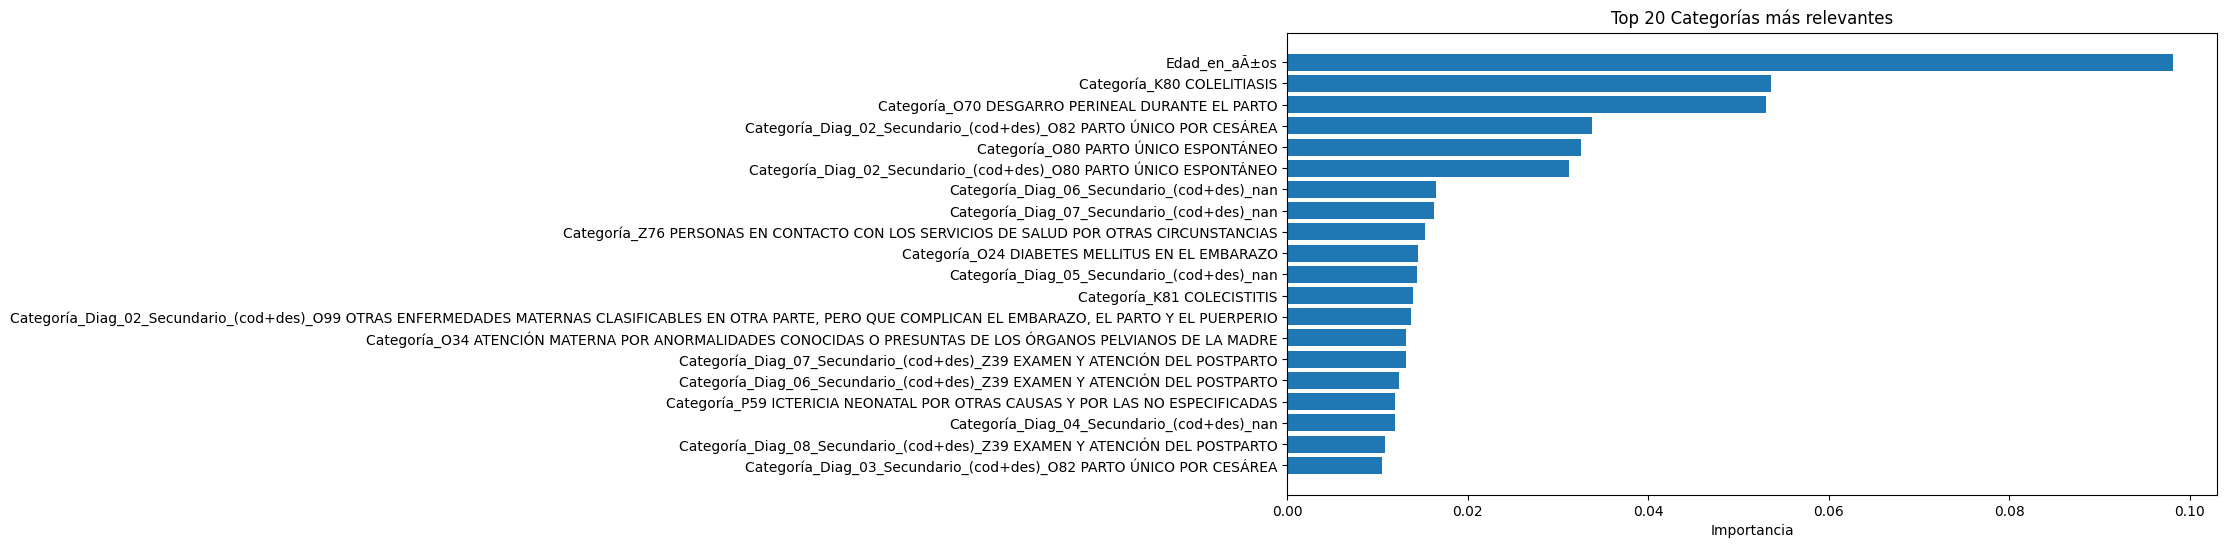

In [14]:
# Obtener nombres de las columnas transformadas
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_feature_names = num_cols + list(cat_feature_names)

# Importancia
importancias = model.feature_importances_

# Mostrar las más importantes
importancia_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importancia": importancias
}).sort_values(by="Importancia", ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df["Feature"][:20][::-1], importancia_df["Importancia"][:20][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 Categorías más relevantes")
plt.tight_layout()
plt.show()

<ipython-input-15-0ad7e3aaebd6>:4: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-0ad7e3aaebd6>:4: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-15-0ad7e3aaebd6>:4: UserWarning: Glyph 141 (\x8d) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 141 (\x8d) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


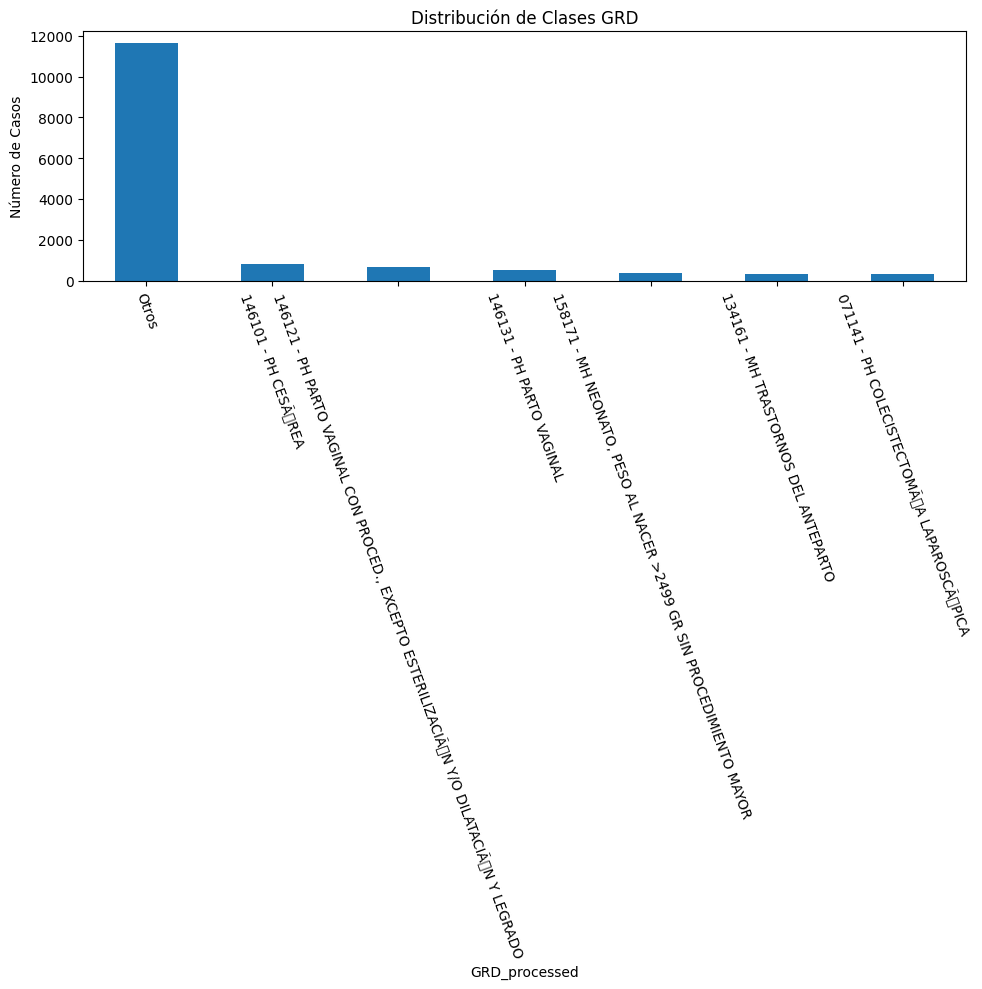

In [15]:
y.value_counts().plot(kind="bar", figsize=(10, 10), title="Distribución de Clases GRD")
plt.xticks(rotation=-70)
plt.ylabel("Número de Casos")
plt.tight_layout()
plt.show()